In [12]:
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 10.1 MB/s eta 0:00:00


In [1]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.5 MB/s eta 0:00:00


In [2]:
!pip install evaluate
!pip install transformers
!pip install datasets

In [3]:
from transformers import AutoTokenizer

tokenizer_xlnet = AutoTokenizer.from_pretrained('xlnet-base-cased')

In [4]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
def tokenize_function_xlnet(examples):
    return tokenizer_xlnet(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets_xlnet = imdb_dataset.map(tokenize_function_xlnet, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
small_train_dataset_xlnet = tokenized_datasets_xlnet["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset_xlnet = tokenized_datasets_xlnet["test"].shuffle(seed=42).select(range(1000))

In [7]:
from transformers import AutoModelForSequenceClassification

model_xlnet = AutoModelForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [8]:
from transformers import TrainingArguments, Trainer

training_args_xlnet = TrainingArguments(output_dir="test_trainer_xlnet", evaluation_strategy="epoch", num_train_epochs=4,
                                      per_device_train_batch_size=8, per_device_eval_batch_size=8)

In [9]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [10]:
trainer_xlnet = Trainer(
    model=model_xlnet,
    args=training_args_xlnet,
    train_dataset=small_train_dataset_xlnet,
    eval_dataset=small_eval_dataset_xlnet,
    compute_metrics=compute_metrics,
)

In [11]:
trainer_xlnet.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.502717,0.879000
2,No log,0.436439,0.894000
3,No log,0.370760,0.920000
4,0.245900,0.462966,0.912000


TrainOutput(global_step=500, training_loss=0.24591993713378907, metrics={'train_runtime': 1288.7725, 'train_samples_per_second': 3.104, 'train_steps_per_second': 0.388, 'total_flos': 1139521118208000.0, 'train_loss': 0.24591993713378907, 'epoch': 4.0})

In [12]:
trainer_xlnet.evaluate()

{'eval_loss': 0.46296560764312744,
 'eval_accuracy': 0.912,
 'eval_runtime': 112.094,
 'eval_samples_per_second': 8.921,
 'eval_steps_per_second': 1.115,
 'epoch': 4.0}

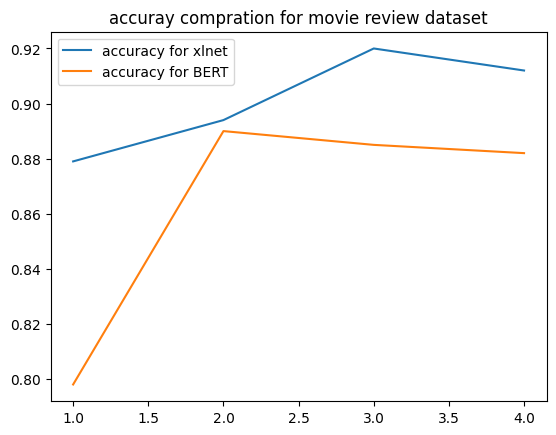

In [19]:
import matplotlib.pyplot as plt

x = range(1, 5)
y_xlnet = [0.879000, 0.894000, 0.920000, 0.912000]
y_bert = [0.798000, 0.890000, 0.885000, 0.882000]
plt.plot(x, y_xlnet, label='accuracy for xlnet')
plt.plot(x, y_bert, label='accuracy for BERT')
plt.title('accuray compration for movie review dataset')
plt.legend()
plt.show()

In [20]:
imdb_dataset['train'][10]

{'text': 'It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn\'t go on to star in more and better films. Sadly, I didn\'t think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat\'s Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is a

In [31]:
imdb_dataset['train'][15000]

{'text': 'Budget limitations, time restrictions, shooting a script and then cutting it, cutting it, cutting it... This crew is a group of good, young filmmakers; thoughtful in this script - yes, allegorical - clever in zero-dollar effects when time and knowledge is all you have, relying on actors and friends and kind others for their time, devotion, locations; and getting a first feature in the can, a 1-in-1000 thing. These guys make films. Good ones. Check out their shorts collection "Heartland Horrors" and see the development. And I can vouch, working with them is about the most fun thing you\'ll do in the business. I\'m stymied by harsh, insulting criticism for this film, wondering if one reviewer even heard one word of dialogue, pondered one thought or concept, or if all that was desired of this work was the visual gore of bashing and slashing to satisfy some mindless view of what horror should mean to an audience. Let "The Empty Acre" bring itself to you. Don\'t preconceive what y

In [30]:
imdb_dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})